In [632]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from PIL import Image, ImageOps, ImageFont, ImageDraw
import csv

import cv2

import pickle

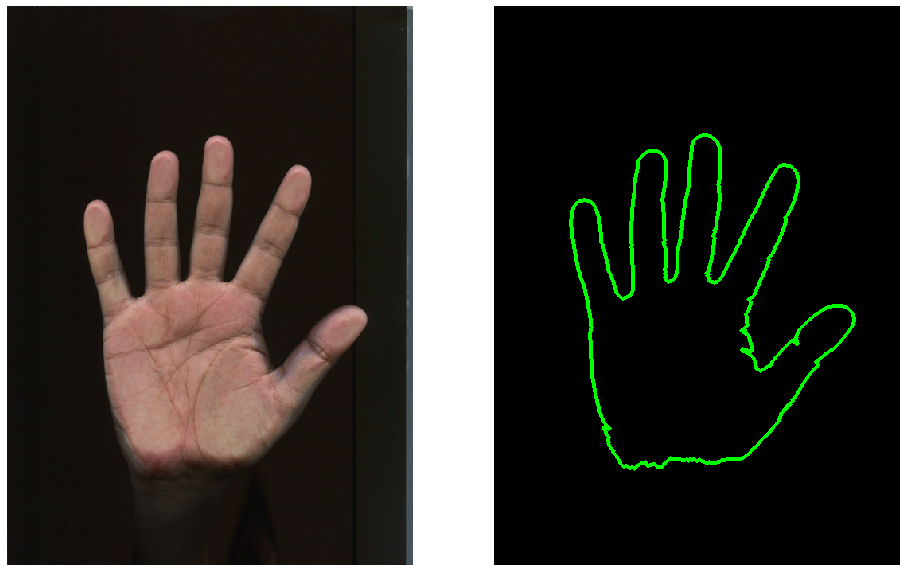

In [633]:
# Load image
image = cv2.imread('training/081.tif')

if True:
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            image[i, j] = image[i, j][::-1]

gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
threshold = gray.copy()
threshold[threshold < 50] = 0
threshold[threshold > 0] = 1

contours, hierarchy = cv2.findContours(threshold, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

filter_contours = sorted(contours, key=cv2.contourArea, reverse=True)
contours = [filter_contours[0]]

image_contours = cv2.drawContours(image * 0, contours, -1, (0,255,0), 3)

# Draw image ans contours
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 16))

ax1.imshow(image)
ax1.axis('off')

ax2.imshow(image_contours)
ax2.axis('off')

plt.show()

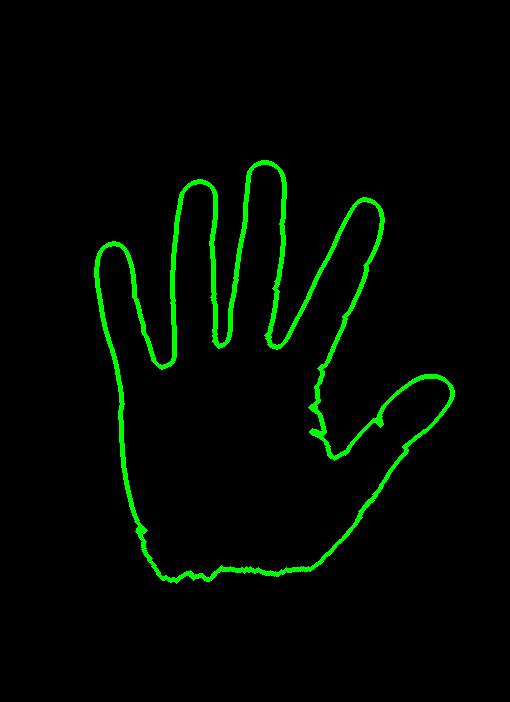

In [634]:
Image.fromarray(image_contours)

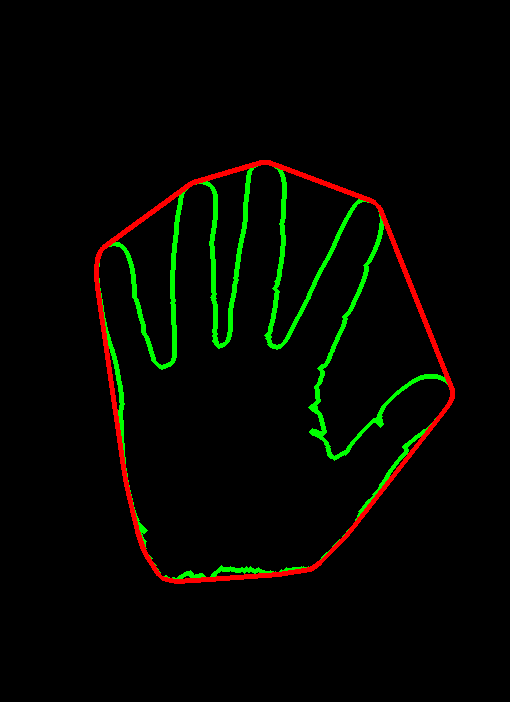

In [635]:
hull = cv2.convexHull(contours[0], returnPoints=False)

Image.fromarray(cv2.drawContours(image_contours, [cv2.convexHull(contours[0])], -1, (255, 0,0), 3))

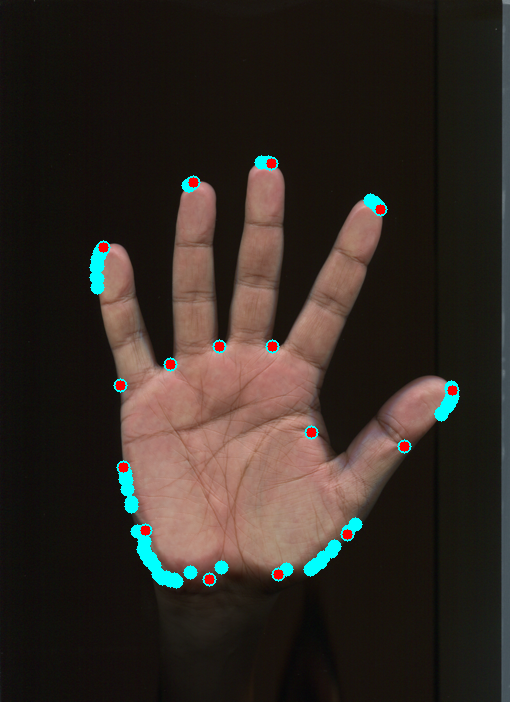

In [636]:
cnt = contours[0]
img = image.copy()
defects = cv2.convexityDefects(cnt,hull)

P = []
for i in range(defects.shape[0]):
    P.append(defects[i, 0][0])
    P.append(defects[i, 0][2])
    P.append(defects[i, 0][1])

K   = [P[0]]
K_i = [0]
for i, p in enumerate(P):
    s = tuple(cnt[K[-1]][0])
    e = tuple(cnt[p][0])
    f = tuple(cnt[K[0]][0])
    if (s[0] - e[0]) ** 2 + (s[1] - e[1]) ** 2 > 4000:
        K.append(p)
        K_i.append(i)
s = tuple(cnt[K[0]][0])
e = tuple(cnt[K[-1]][0])
if (s[0] - e[0]) ** 2 + (s[1] - e[1]) ** 2 < 4000:
    K = K[:len(K) - 1]
    K_i = K_i[:len(K_i) - 1]

for i in range(len(P)):
    cv2.circle(img, tuple(cnt[P[i]][0]), 7, [0,255,255], -1)

       
for i in range(len(K)):
    cv2.circle(img, tuple(cnt[K[i]][0]), 5, [255,0,0], -1)        

Image.fromarray(img)

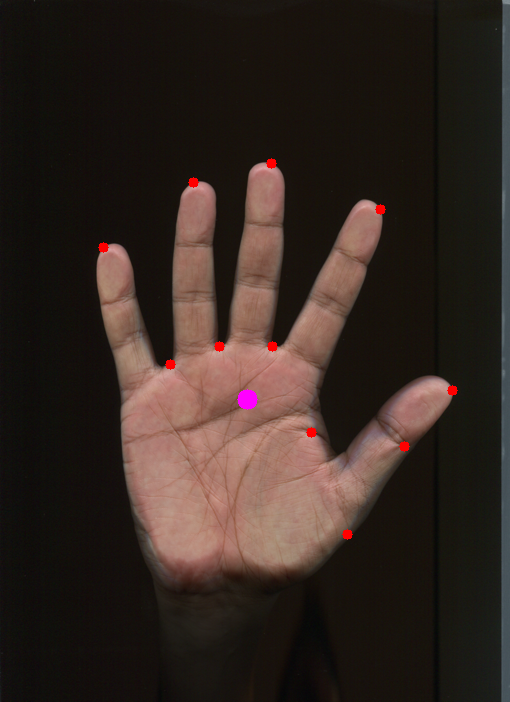

In [637]:
def check(ind):
    pre_is_longer = True
    m = cv2.moments(cnt)
    cen = (int(m['m10'] / m['m00']), int(m['m01'] / m['m00']))
    p = tuple(cnt[K[ind]][0])
    
    pre_dist = (cen[0] - p[0]) ** 2 + (cen[1] - p[1]) ** 2
    for i in range(ind + 1, ind + 9):
        p = tuple(cnt[K[i]][0])
        dist = (cen[0] - p[0]) ** 2 + (cen[1] - p[1]) ** 2
        if dist > pre_dist and pre_is_longer: 
            return False
        if dist < pre_dist and not pre_is_longer:          
            return False
        pre_is_longer = not pre_is_longer
        pre_dist = dist
    for i in range(ind+ 1, ind + 7):
        p1 = tuple(cnt[K[i]][0])
        p2 = tuple(cnt[K[i + 1]][0])
        p3 = tuple(cnt[K[i + 2]][0])
        v1 = (p2[0] - p1[0], p2[1] - p1[1])
        v2 = (p3[0] - p2[0], p3[1] - p2[1])
        if v1[0] * v2[0] + v1[1] * v2[1]  > 0:
            return False
    p1 = tuple(cnt[K[ind]][0])
    p2 = tuple(cnt[K[ind + 8]][0])
    v1 = (p1[0] - cen[0], p1[1] - cen[1])
    v2 = (p2[0] - cen[0], p2[1] - cen[1])
    if v1[0] * v2[1] - v1[1] * v2[0] > 0:
        return False
        
    return True
        
img = image.copy()
m = cv2.moments(cnt)
x = int(m['m10'] / m['m00'])
y = int(m['m01'] / m['m00'])
cen = (x, y)
cv2.circle(img, cen, 10, [255,0,255], -1)
end = -1000
for M in range(-9, len(K) - 8):
    if check(M):
        if M + 8 <= 0:
            end = max(end, len(K) - M - 8)
        else:
            end = max(end, M + 8)
        for i in range(M, M + 9):
            cv2.circle(img, tuple(cnt[K[i]][0]), 5, [255,0,0], -1)
end = end % len(K)    

Image.fromarray(img)      

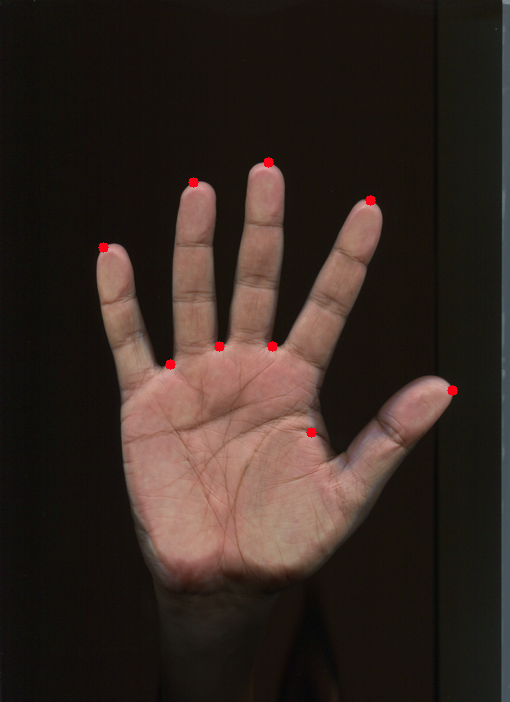

In [638]:
img = image.copy()
hand = []
for i in range(8, -1, -1):
        hand.append(end - i)

dist = 0
ind = 0
r = tuple(cnt[K[hand[3]]][0])
l = tuple(cnt[K[hand[5]]][0])
for i in (range(K_i[hand[3]] + 1, K_i[hand[5]])):
    p = tuple(cnt[P[i]][0])
    if  (l[0] - p[0]) ** 2 + (l[1] - p[1]) ** 2 + (r[0] - p[0]) ** 2 + (r[1] - p[1]) ** 2 > dist:
        dist = (l[0] - p[0]) ** 2 + (l[1] - p[1]) ** 2 + (r[0] - p[0]) ** 2 + (r[1] - p[1]) ** 2
        ind = i
K_i[hand[4]] = ind
K[hand[4]] = P[ind]

dist = 0
ind = 0
r = tuple(cnt[K[hand[1]]][0])
l = tuple(cnt[K[hand[3]]][0])
for i in (range(K_i[hand[1]] + 1, K_i[hand[3]])):
    p = tuple(cnt[P[i]][0])
    if  (l[0] - p[0]) ** 2 + (l[1] - p[1]) ** 2 + (r[0] - p[0]) ** 2 + (r[1] - p[1]) ** 2 > dist:
        dist = (l[0] - p[0]) ** 2 + (l[1] - p[1]) ** 2 + (r[0] - p[0]) ** 2 + (r[1] - p[1]) ** 2
        ind = i
K_i[hand[2]] = ind
K[hand[2]] = P[ind]

p1 = tuple(cnt[K[hand[1]]][0])
p2 = tuple(cnt[K[hand[2]]][0])
v = (p2[0] - p1[0], p2[1] - p1[1])

dist = 0
ind = 0
i = K_i[hand[1]]

while True:
    i -= 1
    p = tuple(cnt[P[i]][0])
    v1 = (p[0] - p1[0], p[1] - p1[1])
    if v[0] * v1[1] - v[1] * v1[0] <= 0:
        break
    if (v[0] * v1[0] + v[1] * v1[1]) / (v[0] ** 2 + v[1] ** 2) ** 0.5 / (v1[0] ** 2 + v1[1] ** 2) ** 0.5 < -1 / 2 ** 0.5:
        break
    
    if v1[0] ** 2 + v1[1] ** 2 > dist:
        dist = v1[0] ** 2 + v1[1] ** 2
        ind = i

K_i[hand[0]] = ind
K[hand[0]] = P[ind]
        
for i in hand:
    cv2.circle(img, tuple(cnt[K[i]][0]), 5, [255,0,25], -1)
    
Image.fromarray(img)

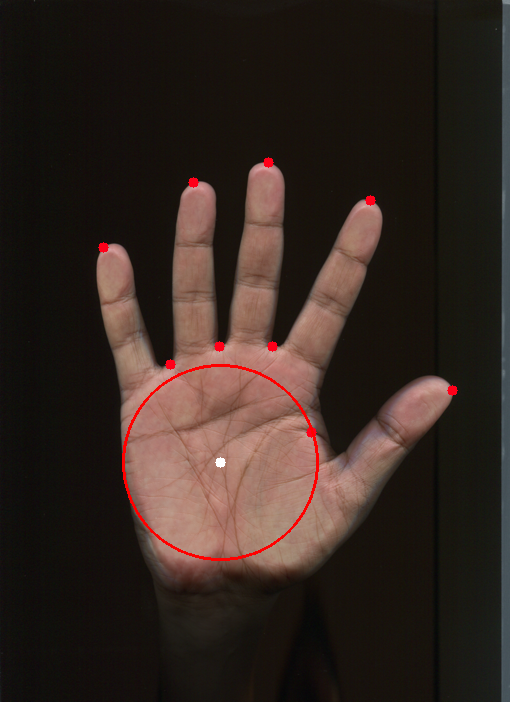

In [639]:
hand_img = cv2.drawContours(image * 0, contours, -1, (255,255,255), -1)[:,:,0]
trans = cv2.distanceTransform(hand_img, cv2.DIST_L2, 5)
min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(trans)

center = max_loc
radius = max_val

cv2.circle(img, max_loc, int(max_val), [255,0,0], 2)
cv2.circle(img, max_loc, 5, [255,255,255], -1)

Image.fromarray(img)

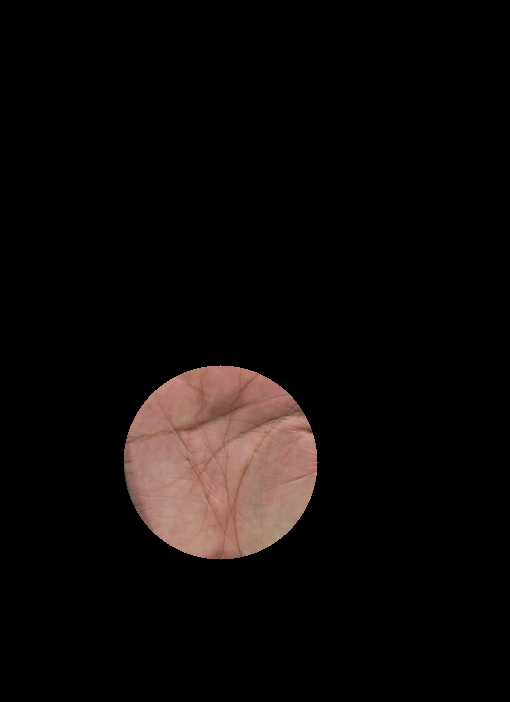

In [640]:
Image.fromarray(image.copy() * cv2.circle(img * 0, max_loc, int(max_val), [1,1,1], -1))

In [645]:
cv2.__version__

'4.2.0'